# Region comparison
Compare different regions

## Preparation
- Imports
- Declare classifiers

In [1]:
from pandas import DataFrame
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from datetime import datetime
from datetime import timedelta

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 7)

classifiers = []

classifiers.append(['Decision Tree', DecisionTreeClassifier()])
classifiers.append(['K Nearest Neighbor', KNeighborsClassifier(n_jobs=-1)])
classifiers.append(['Random Forest', RandomForestClassifier(n_jobs=-1)])
classifiers.append(['XG Boost', XGBClassifier(use_label_encoder=False, verbosity=0)])

classifiers.append(['Decision Tree (optimized)', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None, max_features=None, max_leaf_nodes=50, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, splitter='best')])
classifiers.append(['K Nearest Neighbor (optimized)', KNeighborsClassifier(n_jobs=-1, algorithm='kd_tree', leaf_size=20, n_neighbors=8, p=1, weights='uniform')])
classifiers.append(['Random Forest (optimized)', RandomForestClassifier(n_jobs=-1, class_weight=None, criterion='gini', max_depth=9, max_features='log2', max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=200)])
classifiers.append(['XG Boost (optimized)', XGBClassifier(use_label_encoder=False, verbosity=0, booster='gbtree', colsample_bylevel=0.75, colsample_bynode=1, colsample_bytree=1, gamma=2, learning_rate=0.5, max_delta_step=0, max_depth=6, min_child_weight=1, n_estimators=100, reg_alpha=1, reg_lambda=0, subsample=1, tree_method='hist')])

classifiers.append(['K Nearest Neighbor (maxed)', KNeighborsClassifier(n_jobs=-1, n_neighbors=300)])

## Iterate over regions

In [2]:
%%time
regions = ['DE', 'GB', 'US']
results = pd.DataFrame(columns=['region', 'algorithm', 'accuracy', 'execution_time'])

for region in regions:
    # Data preperation
    df = pd.read_csv('../0_data/' + region + 'videos.csv',
    low_memory=False)

    df['trending_date'] = df.apply(lambda row: datetime.strptime(row['trending_date'], '%y.%d.%m'), axis=1)
    df['publish_time'] = df.apply(lambda row: datetime.strptime(row['publish_time'], '%Y-%m-%dT%H:%M:%S.000Z'), axis=1)
    df['days_until_trending'] = df.apply(lambda row: ((row['trending_date'] - row['publish_time']).days + 1), axis=1)

    df['tags_count'] = df.apply(lambda row: len(row['tags'].split('|')), axis=1)
    df['publish_hour'] = df['publish_time'].map(lambda x: x.hour)
    df['publish_month'] = df['publish_time'].map(lambda x: x.month)
    df['publish_year'] = df['publish_time'].map(lambda x: x.year)
    df['publish_day_of_month'] = df['publish_time'].map(lambda x: x.day)
    df['publish_weekday'] = df['publish_time'].map(lambda x: x.weekday()) # 0: Monday, 6: Sunday

    df['like_dislike_ratio'] = df.apply(lambda row: row['likes'] / (row['dislikes'] + 1), axis=1)
    df['like_view_ratio'] = df.apply(lambda row: row['likes'] / (row['views'] + 1), axis=1)

    df['ratings'] = df['likes'] + df['dislikes']
    df['likes_per_rating'] = df.apply(lambda row: 0 if row['ratings'] == 0 else row['likes'] / row['ratings'], axis=1)
    df['ratings_per_view'] = df['ratings'] / df['views']
    df['comments_per_view'] = df['comment_count'] / df['views']

    def assign_target_category(row):
        if row['days_until_trending'] == 0: 
            return 0
        elif row['days_until_trending'] == 1:
            return 1
        elif row['days_until_trending'] == 2:
            return 2
        elif row['days_until_trending'] <= 5:
            return 3
        else:
            return 6

    df['target_category'] = df.apply(assign_target_category, axis=1)
    df['channel_title'] = df['channel_title'].astype('category')

    tag_df = pd.read_csv('../0_data/' + region + 'tags.csv')
    tag_df = tag_df.set_index('tag')
    def calculate_tag_factor(tag_string, tag_data):
        tag_list = pd.Series(list(set(map(lambda x: x.strip('\"').lower(), tag_string.split('|')))))
        return tag_list.apply(lambda tag: tag_data['factor'].get(tag, np.nan)).mean(skipna=True)
        
    df['tag_factors'] = df['tags'].apply(lambda x: calculate_tag_factor(x, tag_df))
    df['tag_factors'] = df.apply(lambda row: 0 if np.isnan(row['tag_factors']) else row['tag_factors'], axis=1)

    N = len(df)
    dropColumns = ['video_id', 'title', 'tags', 'thumbnail_link', 'description']
    for column in df.columns:
        numberOfUniqueValues = df[column].nunique()
        if numberOfUniqueValues < 2:
            dropColumns.append(column)
        elif df[column].dtype == 'object' and numberOfUniqueValues > N * 0.9:
            dropColumns.append(column)
        elif df[column].isna().sum() / N > 0.95:
            dropColumns.append(column)
            
    df.drop(columns=dropColumns, inplace=True)

    # Encode features
    x_df = DataFrame(index=df.index)
    features = ['views', 'publish_hour', 'ratings_per_view', 'comments_per_view', 'tag_factors']
    for feature in features:
        feature_data = df[feature]
        if df[feature].dtype.name == 'category':
            x_label_encoder = preprocessing.LabelEncoder()
            x_label_encoder.fit(feature_data.astype(str))
            x_df[feature] = x_label_encoder.transform(feature_data)
        elif df[feature].dtype.name == 'datetime64[ns]':
            x_df[feature] = feature_data.to_seconds()
        elif df[feature].dtype.name == 'bool':
            x_df[feature] = int(feature_data)
        else:
            x_df[feature] = feature_data

    x = np.reshape(x_df, (-1, len(x_df.columns)))

    # Encode target
    target = df['target_category'].astype(str)
    y_label_encoder = preprocessing.LabelEncoder()
    y_label_encoder.fit(target)
    y = y_label_encoder.transform(target)

    # Test with multiple train-test splits
    for i in range(5):

        # Create data subsets
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.40, random_state=i)

        # Train model and predict test data
        for classifier in classifiers:
            start_time = time.time()
            classifier[1].fit(x_train, y_train)
            y_pred = classifier[1].predict(x_test)
            execution_time = time.time() - start_time
            result = {'region': region, 'algorithm': classifier[0], 'accuracy': accuracy_score(y_test, y_pred), 'execution_time': execution_time}
            results = results.append(result, ignore_index=True)

Wall time: 2min 43s


## Results

In [3]:
results.head(15)

,region,algorithm,accuracy,execution_time
0,DE,Decision Tree,0.600208,0.141001
1,DE,K Nearest Neighbor,0.589006,0.342000
2,DE,Random Forest,0.681379,0.492002
3,DE,XG Boost,0.676543,3.608000
4,DE,Decision Tree (optimized),0.657505,0.081000
5,DE,K Nearest Neighbor (optimized),0.601310,0.347001
6,DE,Random Forest (optimized),0.677216,0.639000
7,DE,XG Boost (optimized),0.678318,0.905000
8,DE,K Nearest Neighbor (maxed),0.634794,0.712000
9,DE,Decision Tree,0.599290,0.136999


Accuracy

<AxesSubplot:xlabel='region', ylabel='accuracy'>

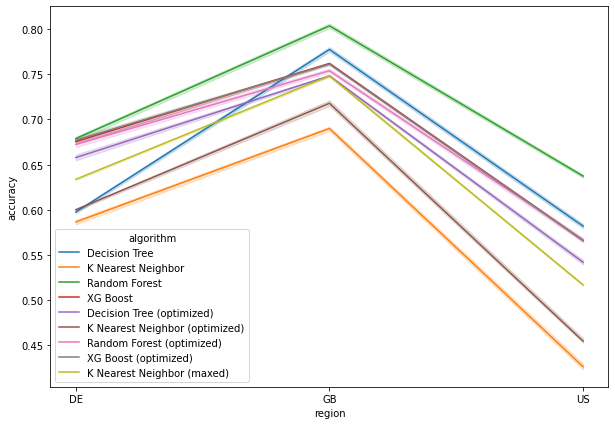

In [4]:
sns.lineplot(data=results, x='region', y='accuracy', hue='algorithm')

Execution time

<AxesSubplot:xlabel='region', ylabel='execution_time'>

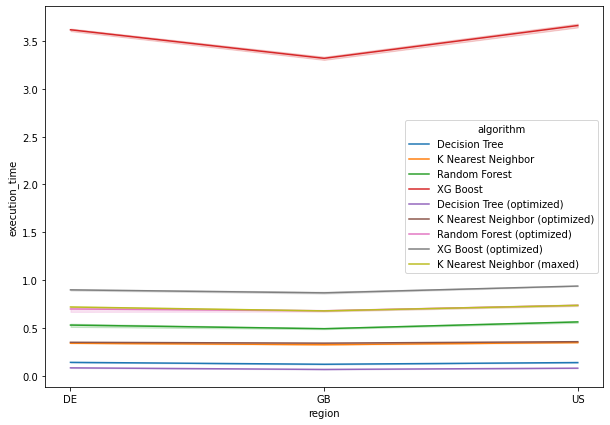

In [5]:
sns.lineplot(data=results, x='region', y='execution_time', hue='algorithm')